In [40]:
from PIL import Image
import matplotlib.pyplot as plt 
import numpy as np
import time

import torch
import torch.nn
import torch.optim as optim
from torchvision import transforms, models

from src.HRNet import HRNet
import src.utils as utils

In [41]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [42]:
# get the VGG19's structure except the full-connect layers
VGG = models.vgg19(pretrained=True).features
VGG.to(device)
print(VGG)
for parameter in VGG.parameters():
    parameter.requires_grad_(False)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [43]:
style_net = HRNet()
style_net.to(device)
print(style_net)

HRNet(
  (pass1_1): BasicBlock(
    (relu): ReLU(inplace=True)
    (identity_block): Sequential(
      (0): ConvLayer(
        (conv): Conv2d(3, 4, kernel_size=(1, 1), stride=(1, 1))
      )
      (1): InstanceNorm2d(4, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (2): ReLU()
      (3): ConvLayer(
        (conv): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (4): InstanceNorm2d(4, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (5): ReLU()
      (6): ConvLayer(
        (conv): Conv2d(4, 16, kernel_size=(1, 1), stride=(1, 1))
      )
      (7): InstanceNorm2d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (8): ReLU()
    )
    (shortcut): Sequential(
      (0): ConvLayer(
        (conv): Conv2d(3, 16, kernel_size=(1, 1), stride=(1, 1))
      )
      (1): InstanceNorm2d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    )
  )
  (pass1_2): BasicBlock(
    

In [44]:
CONTENT = 'img/content/unsplash-tower.jpg'
STYLE = 'img/content/night-sky.jpg'

content_image = utils.load_image(CONTENT, img_size=512)
content_image = content_image.to(device)

style_image = utils.load_image(STYLE, img_size=512)  
style_image = style_image.to(device)

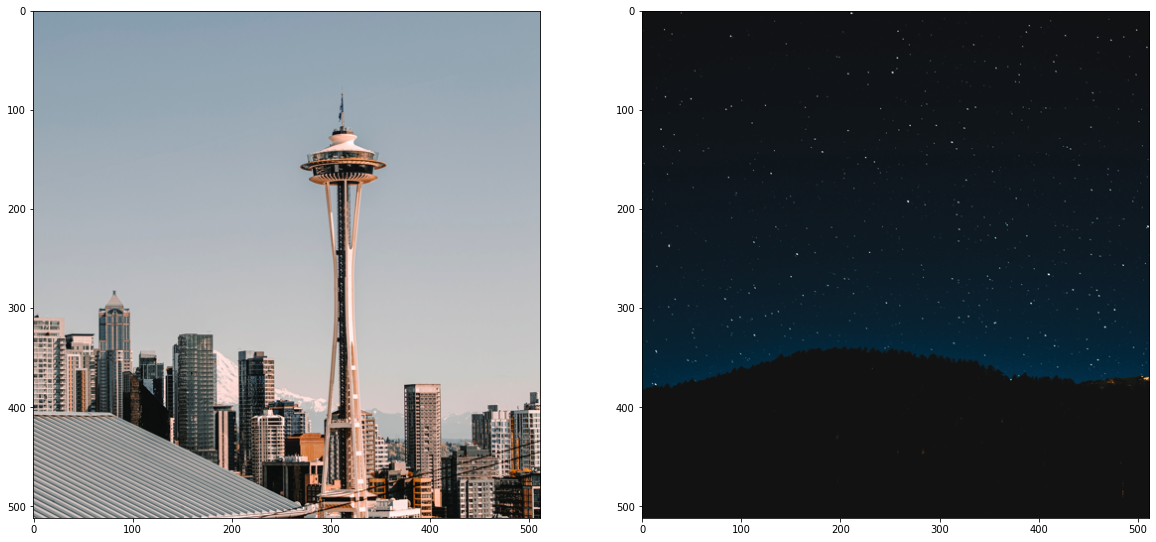

In [45]:
# display the raw images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
# content and style ims side-by-side
ax1.imshow(utils.im_convert(content_image))
ax2.imshow(utils.im_convert(style_image))
plt.show()

In [46]:
content_features = utils.get_features(content_image, VGG)
style_features   = utils.get_features(style_image, VGG)

style_gram_matrixs = {layer: utils.get_grim_matrix(style_features[layer]) for layer in style_features}

target = content_image.clone().requires_grad_(True).to(device)

In [47]:
# try to give fore con_layers more weight so that can get more detail in output iamge
style_weights = {'conv1_1': 0.1,
                 'conv2_1': 0.2,
                 'conv3_1': 0.4,
                 'conv4_1': 0.8,
                 'conv5_1': 1.6}

content_weight = 150
style_weight = 1

show_every = 100
optimizer = optim.Adam(style_net.parameters(), lr=5e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=200, gamma=0.9)
steps = 1000

content_loss_epoch = []
style_loss_epoch = []
total_loss_epoch = []
output_image = content_image

In [53]:
time_start=time.time()
for epoch in range(0, steps+1):
    
    scheduler.step()

    target = style_net(content_image).to(device)
    target.requires_grad_(True)


    target_features = utils.get_features(target, VGG)  # extract output image's all feature maps
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2']) ** 2)
    
    style_loss = 0

    # compute each layer's style loss and add them
    for layer in style_weights:
        
        target_feature = target_features[layer]  # output image's feature map after layer
        target_gram_matrix = utils.get_grim_matrix(target_feature)
        style_gram_matrix = style_gram_matrixs[layer]

        layer_style_loss = style_weights[layer] * torch.mean((target_gram_matrix - style_gram_matrix) ** 2)
        b, c, h, w = target_feature.shape
        style_loss += layer_style_loss / (c * h * w)
    

    total_loss = content_weight * content_loss + style_weight * style_loss
    total_loss_epoch.append(total_loss)

    style_loss_epoch.append(style_weight * style_loss)
    content_loss_epoch.append(content_weight * content_loss)

    optimizer.zero_grad()

    if total_loss is not None:
        total_loss.backward()
    optimizer.step()

    if epoch % show_every == 0:
        print("After %d criterions:" % epoch)
        print('Total loss: ', total_loss.item())
        print('Content loss: ', content_loss.item())
        print('Style loss: ', style_loss.item())
        plt.imshow(utils.im_convert(target))
        plt.show()

    output_image = target
time_end=time.time()
print('totally cost', time_end - time_start)

C:\Users\jerem\AppData\Local\Programs\Python\Python38\lib\site-packages\torch\nn\functional.py:3631: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


RuntimeError: one of the variables needed for gradient computation has been modified by an inplace operation: [torch.FloatTensor [1, 16, 512, 512]], which is output 0 of ReluBackward0, is at version 2; expected version 0 instead. Hint: enable anomaly detection to find the operation that failed to compute its gradient, with torch.autograd.set_detect_anomaly(True).

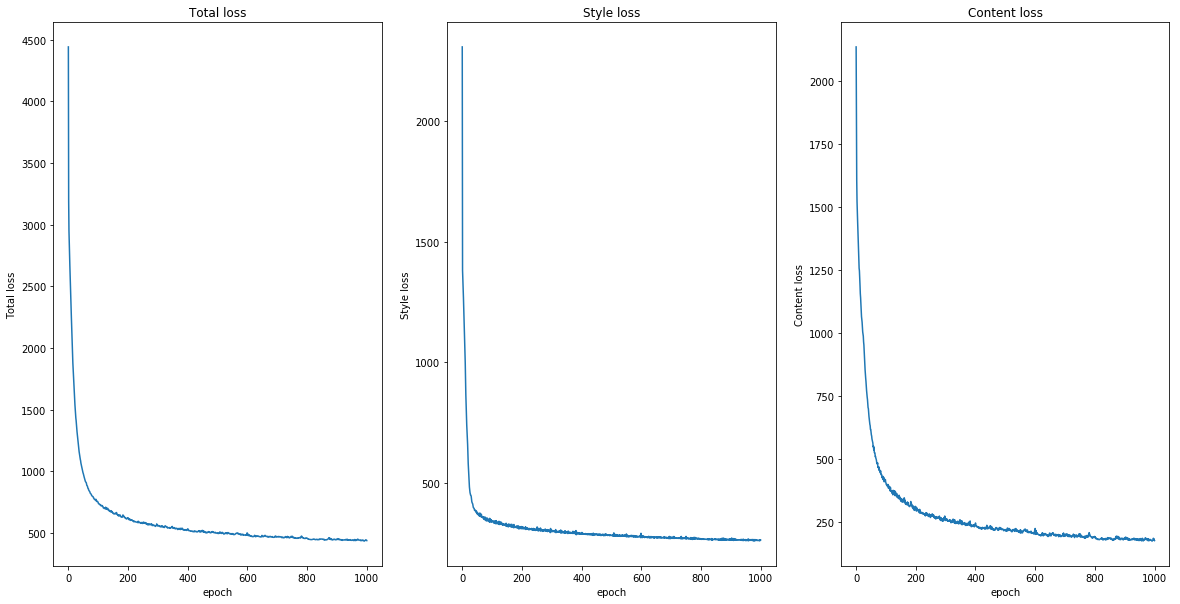

In [10]:
# plot the line chart
epoch = range(0, steps + 1)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10))                                                       

ax1.plot(epoch, total_loss_epoch)
ax1.set_title("Total loss")
ax1.set_xlabel("epoch")
ax1.set_ylabel("Total loss")

ax2.plot(epoch, style_loss_epoch)
ax2.set_title("Style loss")
ax2.set_xlabel("epoch")
ax2.set_ylabel("Style loss")

ax3.plot(epoch, content_loss_epoch)
ax3.set_title("Content loss")
ax3.set_xlabel("epoch")
ax3.set_ylabel("Content loss")


plt.show()

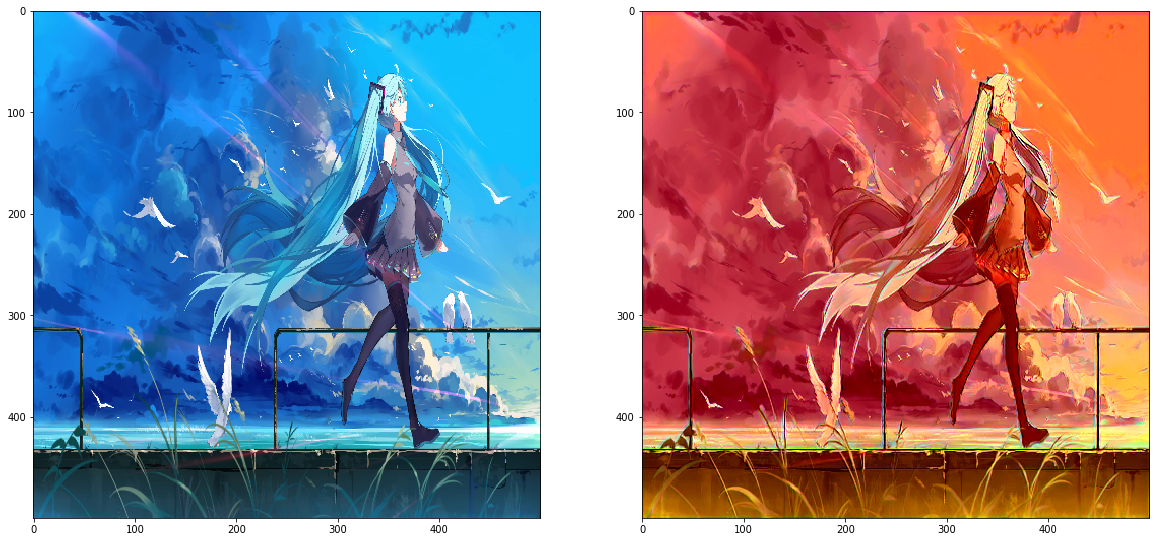

In [11]:
# display the raw images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
# content and style ims side-by-side
ax1.imshow(utils.im_convert(content_image))
ax2.imshow(utils.im_convert(output_image))
plt.show()